In [88]:
import pickle 
import pandas as pd 
import numpy as np
import glob
from os.path import basename
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Get pickle files with Enformer predictions

In [110]:
data_dir = '/shared/shush/jessica_enformer_analysis/enformer_pickles'
pkl_files = glob.glob(data_dir+"/*pickle")
print(len(pkl_files))

2136


# Look at one pickle file

In [111]:
# test w/ one file
test_pkl = pkl_files[0]

with open(test_pkl, 'rb') as handle:
    context_res = pickle.load(handle)

In [113]:
context_res

gene                                                  ENSG00000150990
enhancer_1                                                 chr12.4732
enhancer_2                                                 chr12.4734
gene_chrom                                                      chr12
gene_start                                                  125465243
gene_stop                                                   125465244
enhancer_1_chrom                                                chr12
enhancer_1_start                                            125371666
enhancer_1_stop                                             125372115
enhancer_2_chrom                                                chr12
enhancer_2_start                                            125389008
enhancer_2_stop                                             125389755
element_dist                                                    93777
wt                  [0.064475425, 0.088069506, 0.027678613, 0.0274...
E1 mean             

In [114]:
(context_res['wt'][447]+context_res['wt'][448])/2

0.8462493419647217

In [115]:
context_res['E1 mean'][447:449].mean()

0.8519523

# Get predicted expression for each case tested

In [132]:
results_dict = {}
for f in pkl_files:
    with open(f, 'rb') as handle:
        context_res = pickle.load(handle)
    gene = context_res['gene']
    e1 = context_res['enhancer_1']
    e2 = context_res['enhancer_2']
    wt_pred = context_res['wt'][447:449].mean()
    e1_pred = context_res['E1 mean'][447:449].mean()
    e2_pred = context_res['E2 mean'][447:449].mean()
    both_pred = context_res['E1&E2 mean'][447:449].mean()
    results_dict[int(basename(f).split(".")[0])] = {
                            'file':int(basename(f).split(".")[0]),
                            'gene':gene,
                          'E1':e1,
                          'E2':e2,
                          'WT_pred':wt_pred,
                          'E1_pred':e1_pred,
                          'E2_pred':e2_pred,
                          'joint_pred':both_pred}

In [117]:
# parse into df 
preds_df = pd.DataFrame.from_dict(results_dict, orient='index')
preds_df.reset_index(drop=True,inplace=True)
preds_df.head()

,file,gene,E1,E2,WT_pred,E1_pred,E2_pred,joint_pred
0,4109,ENSG00000150990,chr12.4732,chr12.4734,0.846249,0.851952,0.847826,0.854261
1,230,ENSG00000173465,chr11.3247,chr11.3250,249.996185,250.007263,249.851715,249.920258
2,4085,ENSG00000150991,chr12.4744,chr12.4745,190.351974,190.368500,188.499298,188.091354
3,5202,ENSG00000140511,chr15.3124,chr15.3127,0.292098,0.285433,0.300209,0.294765
4,3928,ENSG00000181788,chr3.4444,chr3.4452,20.367287,17.884382,18.394749,16.156275


In [135]:
# save to df 
preds_df.drop(columns='file').to_csv("enformer_predicted_expr.csv")

In [119]:
# filter for WT>10
preds_df = preds_df[preds_df['WT_pred']>=10]

# Calculate effects for each perturbation (log ratio)

In [58]:
# calculate multiplicative effects of each enhancer (individual)
e1_log_effect = np.log(preds_df['E1_pred'].values) - np.log(preds_df['WT_pred'].values)
e2_log_effect = np.log(preds_df['E2_pred'].values) - np.log(preds_df['WT_pred'].values)

# calculate expected expr of joint perturbation under multiplicative model
mult_joint_expected_expr = np.exp(np.log(preds_df['WT_pred']) + e1_log_effect + e2_log_effect)

In [61]:
# calculate log ratios for expected vs. observed joint effect under multiplicative model
mult_joint_expected_lr = np.log(mult_joint_expected_expr) - np.log(preds_df['WT_pred'].values) # expected based on Enformer predictions for E1 + E2 (individually) - multiplicative
mult_joint_obs_lr = np.log(preds_df['joint_pred'].values) - np.log(preds_df['WT_pred'].values)

# Plot

In [70]:
# generate df for plotting 
plotdf = pd.DataFrame({'WT':preds_df['WT_pred'],
                       'observed':mult_joint_obs_lr,
                       'expected':mult_joint_expected_lr})

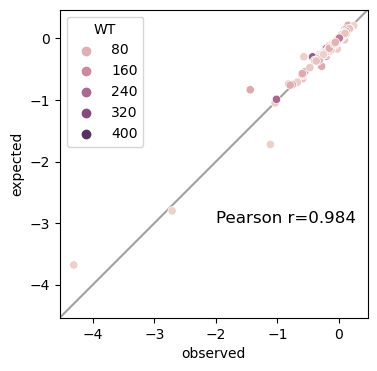

In [101]:
fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(data=plotdf, hue='WT', x='observed', y='expected', ax=ax)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, '-', alpha=0.75, zorder=0, color='grey')
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# pearsonr 
r, p = pearsonr(plotdf['observed'],plotdf['expected'])
plt.text(-2, -3, f'Pearson r={r:.3g}', size=12)
plt.show()